In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_olivier_feature_matrix.csv')
time.time() - st

187.1064031124115

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:45<00:00,  1.16s/it]


36

In [4]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.77106	valid_1's auc: 0.755885
[200]	training's auc: 0.801589	valid_1's auc: 0.772253
[300]	training's auc: 0.821009	valid_1's auc: 0.779543
[400]	training's auc: 0.835955	valid_1's auc: 0.782165
[500]	training's auc: 0.849321	valid_1's auc: 0.7838
[600]	training's auc: 0.861118	valid_1's auc: 0.784438
[700]	training's auc: 0.871617	valid_1's auc: 0.784962
[800]	training's auc: 0.880871	valid_1's auc: 0.785471
[900]	training's auc: 0.889565	valid_1's auc: 0.785352
Early stopping, best iteration is:
[806]	training's auc: 0.881421	valid_1's auc: 0.785502
Fold  1 AUC : 0.785502
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.771189	valid_1's auc: 0.756249
[200]	training's auc: 0.801982	valid_1's auc: 0.773292
[300]	training's auc: 0.821164	valid_1's auc: 0.780136
[400]	training's auc: 0.83632	valid_1's auc: 0.78345
[500]	training's auc: 0.849403	valid_1's auc: 0.785

In [5]:
sub.to_csv('./olivier_feature_matrix_5cv_sub.csv', index=None)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


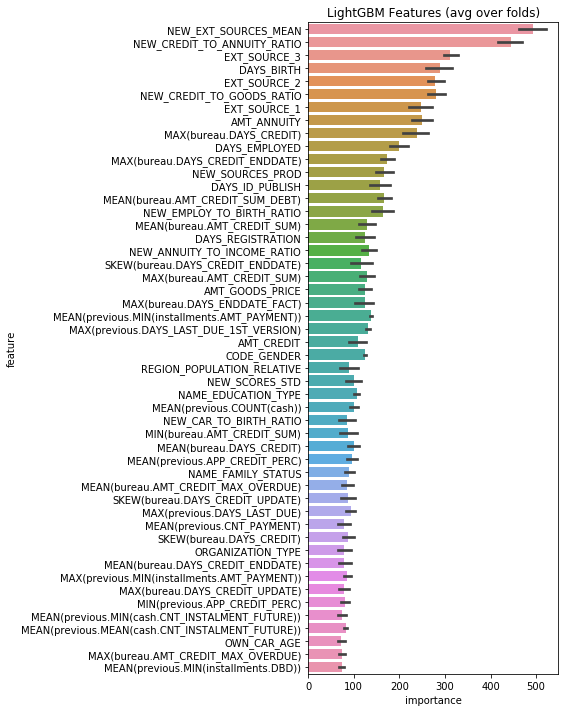

In [7]:
display_importances(feature_importance_df)

In [8]:
time.time() - st

2131.275969982147